<a href="https://colab.research.google.com/github/AJ576/TUMOR_CLASSIFIER/blob/main/THE_BEST_CYCLIC_ALGORITHM!.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

In [ ]:
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import CyclicLR
import torch.nn.functional as F


In [ ]:
batch_size = 64
num_classes = 4
num_epochs = 40  # Total number of epochs
base_lr = 5e-4   # Minimum learning rate (adjusted for exploration)
max_lr = 1.2e-3  # Maximum learning rate (slightly above 0.0009)
step_size_up = 10

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a standard size
    transforms.ToTensor(),          # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize image data
])

In [ ]:
train_dataset = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/Colab Notebooks/MRI/Training', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
test_dataset = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/Colab Notebooks/MRI/Testing', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class ConvNet(nn.Module):
  def __init__(self, num_classes):
        super(ConvNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        # Pooling Layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully Connected Layers
        self.fc1 = nn.Linear(128 * 14 * 14, 512)  # Adjust dimensions if using a different input size
        self.fc2 = nn.Linear(512, num_classes)


        # Dropout
        self.dropout = nn.Dropout(0.5)


  def forward(self, x):
        # Apply Convolutional and Pooling layers
        x = self.pool(F.elu(self.conv1(x)))
        x = self.pool(F.elu(self.conv2(x)))
        x = self.pool(F.elu(self.conv3(x)))
        x = self.pool(F.elu(self.conv4(x)))

        # Flatten for fully connected layers
        x = x.view(-1, 128 * 14 * 14)

        # Fully connected layers with dropout
        x = F.elu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [ ]:
model = ConvNet(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=base_lr)
scheduler = CyclicLR(optimizer, base_lr=base_lr, max_lr=max_lr, step_size_up=step_size_up, mode='triangular')

total_step = len(train_loader)

In [ ]:
writer = SummaryWriter()

for epoch in range(num_epochs):
    # Training loop
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update the learning rate with the scheduler
        scheduler.step()

        # Log training loss and learning rate
        if (i + 1) % 10 == 0:
            writer.add_scalar('training_loss', loss.item(), epoch * total_step + i)
            writer.add_scalar('learning_rate', optimizer.param_groups[0]['lr'], epoch * total_step + i)

    # Save model checkpoint at the end of each epoch
    torch.save(model.state_dict(), f"/content/drive/MyDrive/Colab Notebooks/checkpoints/ELU_CYCLE/model_epoch_{epoch + 1}.pth")

    # Print epoch stats
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, LR: {optimizer.param_groups[0]["lr"]:.6f}')

# Close the SummaryWriter
writer.close()

Epoch [1/40], Loss: 0.5417, LR: 0.000850
Epoch [2/40], Loss: 0.4086, LR: 0.001200
Epoch [3/40], Loss: 0.4040, LR: 0.000850
Epoch [4/40], Loss: 0.3094, LR: 0.000500
Epoch [5/40], Loss: 0.1967, LR: 0.000850
Epoch [6/40], Loss: 0.1021, LR: 0.001200
Epoch [7/40], Loss: 0.0968, LR: 0.000850
Epoch [8/40], Loss: 0.1321, LR: 0.000500
Epoch [9/40], Loss: 0.0102, LR: 0.000850
Epoch [10/40], Loss: 0.0264, LR: 0.001200
Epoch [11/40], Loss: 0.0578, LR: 0.000850
Epoch [12/40], Loss: 0.1086, LR: 0.000500
Epoch [13/40], Loss: 0.0030, LR: 0.000850
Epoch [14/40], Loss: 0.0048, LR: 0.001200
Epoch [15/40], Loss: 0.0452, LR: 0.000850
Epoch [16/40], Loss: 0.0435, LR: 0.000500
Epoch [17/40], Loss: 0.0395, LR: 0.000850
Epoch [18/40], Loss: 0.0404, LR: 0.001200
Epoch [19/40], Loss: 0.0504, LR: 0.000850
Epoch [20/40], Loss: 0.0089, LR: 0.000500
Epoch [21/40], Loss: 0.0087, LR: 0.000850
Epoch [22/40], Loss: 10.8924, LR: 0.001200
Epoch [23/40], Loss: 0.7925, LR: 0.000850
Epoch [24/40], Loss: 0.4625, LR: 0.000500


In [ ]:
with torch.no_grad():
    for epoch in range(num_epochs):
        model.load_state_dict(torch.load(f"/content/drive/MyDrive/Colab Notebooks/checkpoints/ELU_CYCLE/model_epoch_{epoch + 1}.pth"))
        model.to(device)
        print(f"Epoch: {epoch+1}")

        correct = 0  # Reset for each epoch
        total = 0    # Reset for each epoch

        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Accuracy of the network on the {} test images: {} %'.format(len(test_loader.dataset), 100 * correct / total))


<ipython-input-11-35ac93fc1b46>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"/content/drive/MyDrive/Colab Notebooks/checkpoints/ELU_CY

Epoch: 1
Accuracy of the network on the 394 test images: 40.609137055837564 %
Epoch: 2
Accuracy of the network on the 394 test images: 34.51776649746193 %
Epoch: 3
Accuracy of the network on the 394 test images: 54.568527918781726 %
Epoch: 4
Accuracy of the network on the 394 test images: 66.24365482233503 %
Epoch: 5
Accuracy of the network on the 394 test images: 69.28934010152284 %
Epoch: 6
Accuracy of the network on the 394 test images: 71.8274111675127 %
Epoch: 7
Accuracy of the network on the 394 test images: 74.11167512690355 %
Epoch: 8
Accuracy of the network on the 394 test images: 76.14213197969544 %
Epoch: 9
Accuracy of the network on the 394 test images: 73.60406091370558 %
Epoch: 10
Accuracy of the network on the 394 test images: 73.60406091370558 %
Epoch: 11
Accuracy of the network on the 394 test images: 70.05076142131979 %
Epoch: 12
Accuracy of the network on the 394 test images: 71.57360406091371 %
Epoch: 13
Accuracy of the network on the 394 test images: 73.09644670050

In [ ]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the {} test images: {} %'.format(len(test_loader.dataset), 100 * correct / total))

Accuracy of the network on the 394 test images: 75.88832487309645 %


In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/checkpoints/ELU_CYCLE/model_epoch_20.pth"))
# #replace X
model.to(device)

<ipython-input-14-3edcf25a4e8f>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/checkpoints/ELU_CYC

ConvNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25088, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=4, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [ ]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

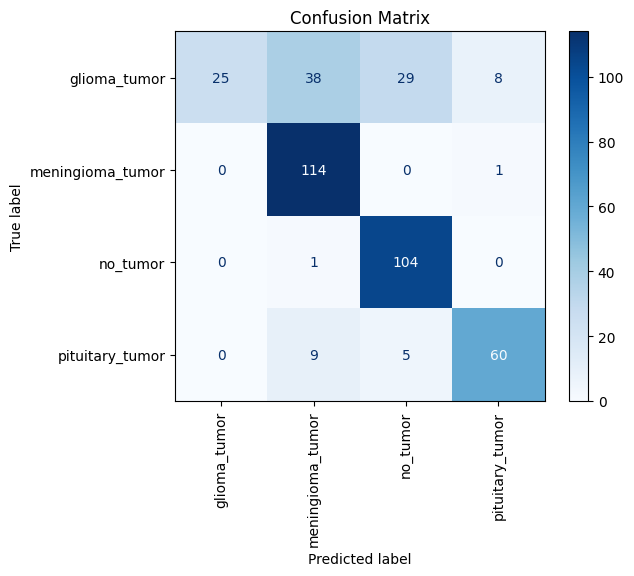

In [ ]:
# Define your test dataset (replace with your actual test loader)
# Assuming test_loader is your DataLoader for the test set

# Define class labels
class_labels = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]

# Ensure the model is in evaluation mode
model.eval()

all_preds = []
all_labels = []

# Iterate through the test data
with torch.no_grad():
    for images, labels in test_loader:  # Replace test_loader with your DataLoader
        images, labels = images.to(device), labels.to(device)

        # Get model predictions
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        # Store predictions and true labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')

# Title for the confusion matrix plot
plt.title("Confusion Matrix")
plt.show()


In [ ]:
print(train_loader.dataset.class_to_idx)


{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
